# Importo las librerías y los dataframes

In [212]:
# importo las librerias necesarias
import pandas as pd
import numpy as np
from pprint import pprint
from utils import clean
general=clean.general
remove_stops = clean.remove_stops
# importo los dataframes
dfLimpio = pd.read_csv('dfLimpio.csv', sep=',', encoding='utf-8')
dfLimpio = dfLimpio.text.apply(str)

# Eliminación de expedientes que no son pericias médicas.

In [213]:
# Elimino expedientes que no son pericuas medicas
noPericiasMedicas=[]
for i,expediente in enumerate(dfLimpio):
    exp = general(expediente)
    if len(exp.split()) < 300:
        totalPalabras = len(exp.split())
        noPericiasMedicas.append((i, expediente, totalPalabras))
        dfLimpio = dfLimpio.drop(i)

dfNoPericiasMedicas = pd.DataFrame(noPericiasMedicas,columns=['ide','expediente', 'total de palabras'])

In [214]:
dfLimpio.reset_index(drop=True, inplace=True)

# Busqueda de titulos

## Títulos con números romanos y en mayúsculas

In [215]:
import re
# Busca títulos en mayusculas
def buscarTitulosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.) ]+[A-Z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []

    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8:
            titulosMayusculasEncontrados.append(m.group())

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosMayusculas=[]
for expediente in dfLimpio:
    titulosMayusculas.append(buscarTitulosMayusculas(expediente))

dfTitulosMayusculasConStops = pd.DataFrame(titulosMayusculas)


# Creacion de dataframe de solo titulos en mayusculas

In [216]:
# Creamos un dataframe para guardar expedientes que solamente tienen titulos en mayusculas
# Guardo en dfTitulosMayusculas los expedientes y su indice dentro del dataframe limpio (con todos los expedientes)
expConTitulosMayusculas = []
expSinTitulosEncontrados = []
for id,titulo in  enumerate(dfLimpio):
    if len(titulosMayusculas[id]) > 0:
        expConTitulosMayusculas.append((id,titulo))
    else:
        expSinTitulosEncontrados.append((id,titulo))


dfExpTitulosMayusculas = pd.DataFrame(expConTitulosMayusculas, columns=['ide','expediente'])
dfExpSinTitulosRomanos = pd.DataFrame(expSinTitulosEncontrados, columns=['ide','expediente'])
#pprint(dfTitulosMayusculas)

In [217]:
# dfExpSinTitulosRomanos['expediente'] = dfExpSinTitulosRomanos['expediente'].apply(remove_stops)
# dfSinTitulosEncontrados['expediente'] = dfSinTitulosEncontrados['expediente'].apply(limpiarDfSinTitulos) #TENER EN CUENTA USAR

In [218]:
dfExpTitulosMayusculas.to_csv('df_ExpTitulosMayusculas.csv',index=False)
dfExpSinTitulosRomanos.to_csv('df_ExpSinTitulosRomanos.csv',index=False)

# NUEVAS BUSQUEDAS
### Títulos con números latinos y romanos en mayúsculas. Escritos en mayusculas y minusculas.

In [219]:
# Busca títulos en mayusculas o minusculas comenzados con numeros latinos o romanos
def buscarTitulosLatinosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'((I{1,3}|IV|V|VI{1,3}|IX|X)|[0-9])[.) -]+[A-Za-z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []
    #i=1
    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8 and len(m.group().split()) <= 12:# and re.findall(str(i),m.group()):
            titulosMayusculasEncontrados.append(m.group())


    return titulosMayusculasEncontrados
# titulosLatinosMayusculas: lista que guarda los títulos encontrados
titulosLatinosMayusculas=[]
for expediente in dfExpSinTitulosRomanos['expediente']:
    #if len(buscarTitulosLatinosMayusculas(expediente)) > 3:
    titulosLatinosMayusculas.append(buscarTitulosLatinosMayusculas(expediente))

# Dataframe de títulos candidatos

In [220]:
from utils import cleanText
limpiar_palabras = cleanText.limpiar_palabras

# Encontrar la ubicacion del titulo en el documento
titulosCandidatos=[]
tipo='candidato'
expSinTitulosEncontrados = dfExpSinTitulosRomanos['expediente'].apply(str)
for i in range(len(expSinTitulosEncontrados)):
    for titulo in titulosLatinosMayusculas[i]:
        inicioTitulo = expSinTitulosEncontrados[i].index(titulo)
        caracteres = len(titulo)
        titulo = re.sub('[-]',' ',titulo)
        titulo = limpiar_palabras(titulo)
        palabrasPorTitulo = len(titulo.split())
        finalTitulo = inicioTitulo + caracteres
        titulosCandidatos.append((i,tipo,titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))

dfUbicacionTitulosCandidatos = pd.DataFrame(titulosCandidatos,columns=['ide','tipo','titulo','inicio','fin','longitud'])

In [221]:
dfUbicacionTitulosCandidatos.to_csv('df_ubicacionTitulosCandidatos.csv',index=False)

In [222]:
# Creamos un dataframe para guardar expedientes que no tienen ningun titulo candidato

# Guardo en dfSinTitulos los expedientes y su indice que no tienen titulos candidatos en el dataframe dfSinTitulosEncontrados
expConTitulosCandidatos = []
expSinTitulos=[]
for id,titulo in  enumerate(dfExpSinTitulosRomanos['expediente']):
    if len(titulosLatinosMayusculas[id]) > 0:
        expConTitulosCandidatos.append((id,titulo))
    else:
        expSinTitulos.append((id,titulo))

dfExpTitulosCandidatos = pd.DataFrame(expConTitulosCandidatos, columns=['ide','expediente'])
dfExpSinTitulosEncontrados = pd.DataFrame(expSinTitulos, columns=['ide','expediente'])

In [223]:
dfExpTitulosCandidatos.to_csv('df_ExpTitulosCandidatos.csv',index=False)
dfExpSinTitulosEncontrados.to_csv('df_ExpSinTitulosEncontrados.csv',index=False)

# Expedientes con títulos candidatos y expedientes sin títulos localizados.

In [224]:
print(f'''
Cantidad de expediente que tienen titulos candidatos:        {len(dfExpTitulosCandidatos)}
Cantidad de expedientes que no tienen titulos localizados:    {len(dfExpSinTitulosEncontrados)}  
Total de expedientes: {len(dfExpSinTitulosRomanos)} ''')


Cantidad de expediente que tienen titulos candidatos:        1969
Cantidad de expedientes que no tienen titulos localizados:    73  
Total de expedientes: 2042 


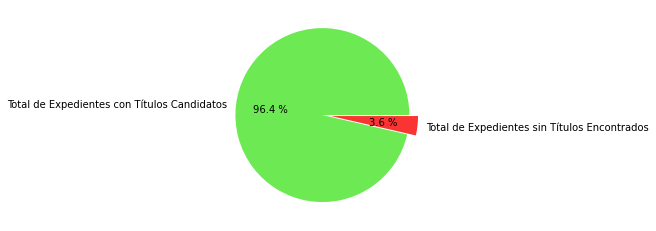

In [225]:
# Creo un grafico de torta
import matplotlib.pyplot as plt

totalExp = len(dfExpTitulosCandidatos)
totalExpSinEncontrar = len(dfExpSinTitulosEncontrados)

# Creación de grafico de torta de la cantidad de expedientes con títulos en mayúsculas sobre el total de expedientes.
cantExp = [totalExp, totalExpSinEncontrar]
nombreTitulos = ['Total de Expedientes con Títulos Candidatos', 'Total de Expedientes sin Títulos Encontrados']
colores = ['#6DEA53','#FA3333']
desfase=(0,0.1)

plt.pie(cantExp, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt.show()

### Títulos con números romanos en minusculas. Escritos en mayusculas y minusculas.

In [226]:
# Busca títulos en mayusculas o minusculas que comienzan con numeros romanos en minuscula.
def buscarTitulosRomanosMinusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(i{1,3}|iv|v|vi{1,3}|ix|x)[.)-]+[A-Za-z -]+[:\.\n]') #[1-9]|
    titulosMayusculasEncontrados = []
    #i=1
    for m in tituloMayusculas.finditer(text):
        if len(m.group()) > 8 and len(m.group().split()) <= 5:# and re.findall(str(i),m.group()):
            titulosMayusculasEncontrados.append(m.group())
            #i=i+1

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosRomanosMinusculas=[]
for expediente in dfExpSinTitulosRomanos['expediente']:
    if len(buscarTitulosRomanosMinusculas(expediente)) > 3:
        titulosRomanosMinusculas.append(buscarTitulosRomanosMinusculas(expediente))

In [227]:
dfExpTitulosMayusculas.to_excel('df_expTitulosMayusculas.xlsx', index=False)

# Expedientes con titulos en mayusculas, con titulos candidatos, sin titulos encontrados. Total de expedientes

In [228]:
print(f'''
Cantidad de expedientes que no son pericias médicas:             {len(dfNoPericiasMedicas)}
Cantidad de expedientes que tienen títulos en mayúsculas:        {len(dfExpTitulosMayusculas)+443}
Cantidad de expedientes que tienen títulos candidatos:           {len(dfExpTitulosCandidatos)-443}
Cantidad de expedientes que no tienen títulos localizados:       {len(dfExpSinTitulosEncontrados)}  
Total de expedientes:                                            {len(dfLimpio)+len(dfNoPericiasMedicas)} ''')


Cantidad de expedientes que no son pericias médicas:             618
Cantidad de expedientes que tienen títulos en mayúsculas:        1589
Cantidad de expedientes que tienen títulos candidatos:           1526
Cantidad de expedientes que no tienen títulos localizados:       73  
Total de expedientes:                                            3806 


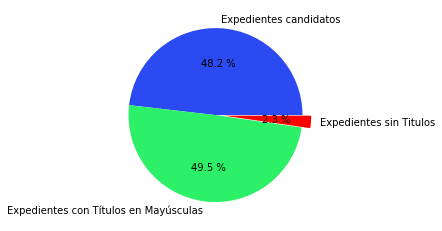

In [229]:
# Creo un grafico de torta expedientes por tipo de busqueda.
import matplotlib.pyplot as plt

totalCandidatos = len(dfExpTitulosCandidatos)-433
totalExpMayusculas = len(dfExpTitulosMayusculas)+433#nuevos candidatos encontrados.
totalSinTitulos = len(dfExpSinTitulosEncontrados)

# Creación de grafico de torta de la cantidad de expedientes con títulos en mayúsculas sobre el total de expedientes.
cantExp = [totalCandidatos, totalExpMayusculas, totalSinTitulos]
nombreTitulos = ['Expedientes candidatos', 'Expedientes con Títulos en Mayúsculas', 'Expedientes sin Titulos']
colores = ['#2C4AF1','#2CF168', 'r']
desfase=(0,0,0.1)

plt.pie(cantExp, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt.show()

# TÍTULOS ENCONTRADOS Y UBICACIÓN

In [230]:
# Encontrar la ubicacion del titulo en el documento
titulosPosicion=[]

for titulo in titulosMayusculas[0]:
    inicioTitulo = dfLimpio[0].index(titulo)
    palabrasPorTitulo = len(titulo)
    finalTitulo = inicioTitulo + palabrasPorTitulo
    titulosPosicion.append((titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))

pprint(titulosPosicion)

[('I-PROEMIO:', 155, 165, 10),
 ('II-ANTECEDENTES DE INTERES MEDICO-LEGAL:', 691, 731, 40),
 ('III-EXAMEN FISICO DEL ACTOR:', 1893, 1921, 28),
 ('IV-CONSIDERACIONES MEDICO-LEGALES:', 9211, 9245, 34),
 ('VII-CONCLUSIONES.', 19083, 19100, 17),
 ('VII-INCAPACIDAD:', 20842, 20858, 16),
 ('VIII CONTESTACION DE LOS PUNTOS DE PERICIA:', 21159, 21202, 43),
 ('IX-PETITORIO:', 21316, 21329, 13)]


In [231]:
# Creo una variable que contiene el párrafo de un título en particular
parrafoConsideraciones = dfLimpio[0][160:611]
parrafoHTML = dfLimpio[0][160:611]
#parrafoConsideraciones = general(parrafoConsideraciones)
parrafoConsideraciones = remove_stops(parrafoConsideraciones)
parrafoConsideraciones = limpiar_palabras(parrafoConsideraciones)
pprint(parrafoConsideraciones)
pprint(f'LONGITUD DE PALABRAS: {len(parrafoConsideraciones.split())}')

('emio juez nacional hortas maria andrea perito medico oficio siguientes autos '
 'domicilio constituido calle austria piso dpto capital domicilio electronico '
 'mashortas cumplimiento dispuesto referente presentes autos despues haber '
 'examinado dijo boiero franco ivan tomaron momento examen clinico actual '
 'consideraron capacidad')
'LONGITUD DE PALABRAS: 40'


# DATAFRAME DE UBICACIÓN DE TÍTULOS ENCONTRADOS

In [232]:
# Encontrar la ubicacion del titulo en el documento
titulosPosicion1=[]
expedientesRaros = []
tipo='encontrado'
for i in range(len(dfLimpio)):
    for titulo in titulosMayusculas[i]:
        inicioTitulo = dfLimpio[i].index(titulo)
        caracteres = len(titulo)
        titulo = re.sub('[\n\.):-]',' ',titulo)
        titulo = limpiar_palabras(titulo)
        palabrasPorTitulo = len(titulo.split())
        finalTitulo = inicioTitulo + caracteres
        #if palabrasPorTitulo > 0:
        titulosPosicion1.append((i, tipo, titulo, inicioTitulo, finalTitulo, palabrasPorTitulo))
        #else:
         
        #   expedientesRaros.append((i, str(dfLimpio[i])))

dfUbicacionTitulos = pd.DataFrame(titulosPosicion1,columns=['ide','tipo','titulo','inicio','fin','longitud'])

# BORRAR PALABRAS QUE NO SON TÍTULOS

In [233]:
dfUbicacionTitulos = dfUbicacionTitulos.drop(dfUbicacionTitulos[dfUbicacionTitulos['titulo'] ==''].index)
#Aplicando esto, de 5671 filas, se reduce a 5286. 

## Calculo de la longitud de los párrafos

In [234]:
dfUbicacionTitulos.reset_index(drop=True, inplace=True)

In [235]:
# Calculo la longitud de caracteres de parrafos
def longitud_parrafos(ubicacion, original):
    parrafos=[]
    for i in range(len(ubicacion)):
        if i < len(ubicacion)-1:
            inicio = ubicacion['inicio'][i]
            fin = ubicacion['inicio'][i+1]
            idDf = ubicacion['ide'][i]
            if (fin-inicio) > 0:
                parrafo = original[idDf][inicio:fin]
                parrafo = remove_stops(parrafo)
                parrafo = general(parrafo)
               
                #parrafo = limpiar_palabras(parrafo)
                caracteres = len(parrafo.split())
                parrafos.append(caracteres)
            else:
                parrafo = original[idDf][inicio:]
                parrafo = general(parrafo)
                parrafo = remove_stops(parrafo)
                parrafo = limpiar_palabras(parrafo)
                caracteres = len(parrafo.split())
                parrafos.append(caracteres)
        else:
            inicio = ubicacion['inicio'][i]
            idDf = ubicacion['ide'][i]
            parrafo = original[idDf][inicio:]
            parrafo = general(parrafo)
            parrafo = remove_stops(parrafo)
            parrafo = limpiar_palabras(parrafo)
            caracteres = len(parrafo.split())
            parrafos.append(caracteres)
    return parrafos

longitudP = longitud_parrafos(dfUbicacionTitulos, dfLimpio)

In [236]:
dfUbicacionTitulos['longitud_parrafo'] = pd.DataFrame(longitudP)

### Creo los dataframes con la ubicación de los títulos encontrados

In [237]:
dfUbicacionTitulos['titulo'].to_csv('titulosEncontrados.csv',index=False)
dfUbicacionTitulos.to_csv('df_TitulosEncontrados.csv',index=False)
dfUbicacionTitulos.to_excel('df_TitulosEncontrados.xlsx',index=False)

### Creo los dataframes con la ubicación de los títulos candidatos

In [238]:
dfUbicacionTitulosCandidatos.to_csv('df_titulosCandidatos.csv',index=False)
dfUbicacionTitulosCandidatos.to_excel('df_titulosCandidatos.xlsx', index=False)
dfUbicacionTitulosCandidatos['titulo'].to_csv('titulosCandidatos.csv',index=False)

In [239]:
dfUbicacionTitulos['longitud'].describe()

count    5179.000000
mean        2.418034
std         1.263013
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: longitud, dtype: float64

In [240]:
# Limpieza de parrafos
# Creo una lista de parrafos
def extraer_parrafos(ubicacion, original):
    parrafos=[]
    for i in range(len(ubicacion)):
        if i < len(ubicacion)-1:
            inicio = ubicacion['fin'][i]
            fin = ubicacion['inicio'][i+1]
            idDf = ubicacion['ide'][i]
            if (fin-inicio) > 0:
                parrafo = original[idDf][inicio:fin]
                caracteres = general(parrafo)
                caracteres = remove_stops(caracteres)
                caracteres = limpiar_palabras(caracteres)
                caracteres = caracteres.split(sep=' ')
                parrafos.append(caracteres)
            else:
                parrafo = original[idDf][inicio:]
                caracteres = general(parrafo)
                caracteres = remove_stops(caracteres)
                caracteres = limpiar_palabras(caracteres)
                caracteres = caracteres.split(sep=' ')
                parrafos.append(caracteres)
    return parrafos

parrafos = extraer_parrafos(dfUbicacionTitulos,dfLimpio)

In [241]:
print(f'LONGITUD DE PALABRAS: {len(parrafos[0])}')

LONGITUD DE PALABRAS: 45


# CREACION DE DOCUMENTO HTML
## MUESTRO LOS TITULOS Y PARRAFOS ENCONTRADOS

In [242]:
# Creamos un dataframe para colocar el salto de linea en formato HTML
dfLimpioHTML = dfLimpio.apply(str)
def limpiarTextoHTML(text):
    text = text.strip().replace('\n','<br>')
    return text

dfLimpioHTML = dfLimpioHTML.apply(limpiarTextoHTML)
parrafoHTML = limpiarTextoHTML(parrafoHTML)

In [243]:
colors = {
    'procedimientos': '#cd5c5c',
    'cuerpos': '#99ccff',
    'afecciones': '#ffa500'
}

body = f'''
        <p>
        {dfLimpioHTML[0]}
        </p>
        <br>
        '''
body = body.replace(parrafoHTML,f'<span style="background-color: #99ccff">{parrafoHTML}</span>')
for titulo in titulosMayusculas[0]:
    body = body.replace(titulo,f'<span style="background-color: #cd5c5c">{titulo}</span>')
with open('parrafos.html','w', encoding="utf-8") as f:
    f.write(body)

# Gráfico de frecuencia de palabras por párrafo. Histograma.

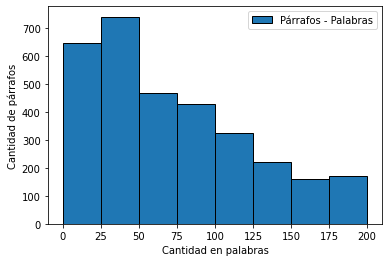

In [244]:
import matplotlib.pyplot as plt

longParrafos = dfUbicacionTitulos['longitud_parrafo']
bins1 = [0, 25, 50, 75, 100, 125, 150, 175, 200] #, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000

plt.hist(longParrafos, bins1, edgecolor='black', label='Párrafos - Palabras')
plt.xlabel('Cantidad en palabras')
plt.ylabel('Cantidad de párrafos')
plt.legend()
plt.show()

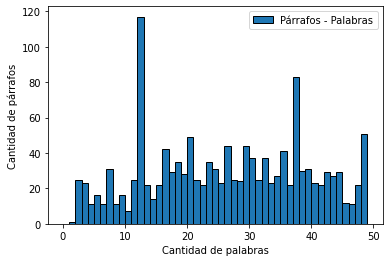

In [245]:
import matplotlib.pyplot as plt

longParrafos = dfUbicacionTitulos['longitud_parrafo']
#bins2 = [0,50, 100,150, 200,250, 300,350, 400,450, 500,550, 600,650, 700,750, 800,850, 900,950, 1000]#[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] #, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000

plt.hist(longParrafos, bins=range(0,50,1),ec='k',label='Párrafos - Palabras', align='mid')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Cantidad de párrafos')
plt.legend()
#plt.axis([1,100,1,300])
plt.show()
# total de parrafos 5775
# limpiar titulos con parrafos de menos de 10 palabras.

# Gráfico de frecuencia de palabras por párrafo. BoxPlot.

In [246]:
# Elimino titulos en blanco y de longitud de parrafos mayores a 800 palabras para poder mejorar el grafico
dfUbicacionTitulosLimpio = dfUbicacionTitulos.drop(dfUbicacionTitulos[dfUbicacionTitulos['titulo'] ==''].index)
dfUbicacionTitulosLimpio = dfUbicacionTitulos.drop(dfUbicacionTitulos[dfUbicacionTitulos['longitud_parrafo'] > 800].index)
longParrafosBox = dfUbicacionTitulosLimpio['longitud_parrafo']

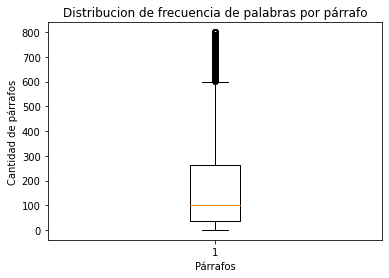

In [247]:
# BoxPlot de distribucion de palabras por parrafos.
plt.boxplot(longParrafosBox)
plt.title('Distribucion de frecuencia de palabras por párrafo')
plt.xlabel('Párrafos')
plt.ylabel('Cantidad de párrafos')
plt.show()

In [248]:
longParrafosBox.describe()

count    4635.000000
mean      182.145847
std       191.831218
min         1.000000
25%        39.000000
50%       101.000000
75%       264.500000
max       799.000000
Name: longitud_parrafo, dtype: float64

# PRUEBAS

In [249]:
# Se unen los dos dataframes en uno solo: Guardo los titulos encontrados y titulos candidatos en un solo dataframe
dfTitulos = pd.concat([dfUbicacionTitulos, dfUbicacionTitulosCandidatos], ignore_index=True)

# Se seleccionan y renombran las columnas de interés
dfTitulos = dfTitulos[['ide', 'tipo', 'titulo', 'inicio', 'fin', 'longitud']]
dfTitulos.columns = ['ide', 'tipo', 'titulo', 'inicio', 'fin', 'longitud']

In [250]:
# Guardo los titulos encontrados y titulos candidatos en un solo dataframe y lo convierot a un archivo .csv
dfTitulos.to_csv('dftitulos.csv',index=False)

In [251]:
def limpiar_tokenizar(text):
    tokenizado=[]
    for titulo in text:
        # Tokenización por palabras individuales
        tokenizado.append(titulo.split(sep = ' '))
    return(tokenizado)

In [252]:
dfTitulos['titulo_tokenizado'] = limpiar_tokenizar(dfTitulos['titulo'])
dfTitulos[['titulo', 'titulo_tokenizado']].head()

,titulo,titulo_tokenizado
0,proemio,[proemio]
1,antecedentes interes medico legal,"[antecedentes, interes, medico, legal]"
2,examen fisico actor,"[examen, fisico, actor]"
3,consideraciones medico legales,"[consideraciones, medico, legales]"
4,conclusiones,[conclusiones]


In [253]:
# Unnest de la columna titulo_tokenizado
# ==============================================================================
titulos_tidy = dfTitulos.explode(column='titulo_tokenizado')
titulos_tidy = titulos_tidy.drop(columns='titulo')
titulos_tidy = titulos_tidy.drop(columns='longitud')
titulos_tidy = titulos_tidy.rename(columns={'titulo_tokenizado':'token'})
titulos_tidy = titulos_tidy.drop(titulos_tidy[titulos_tidy['token'] ==''].index)
titulos_tidy.head(3)

,ide,tipo,inicio,fin,token
0,0,encontrado,155,165,proemio
1,0,encontrado,691,731,antecedentes
1,0,encontrado,691,731,interes


In [254]:
#titulos_tidy.reset_index(drop=True, inplace=True)

## Frecuencia de título

In [255]:
# Palabras totales utilizadas por cada autor
# ==============================================================================
print('--------------------------')
print('Palabras totales por títulos')
print('--------------------------')
titulos_tidy.groupby(by='tipo')['token'].count()

--------------------------
Palabras totales por títulos
--------------------------


tipo
candidato     73528
encontrado    12523
Name: token, dtype: int64

In [256]:
# Palabras distintas por títulos
# ==============================================================================
print('----------------------------')
print('Palabras distintas por títulos')
print('----------------------------')
titulos_tidy.groupby(by='tipo')['token'].nunique()

----------------------------
Palabras distintas por títulos
----------------------------


tipo
candidato     6670
encontrado     955
Name: token, dtype: int64

In [257]:
# Longitud media y desviación de los titulos de cada tipo
# ==============================================================================
temp_df = pd.DataFrame(titulos_tidy.groupby(by = ["tipo", "ide"])["token"].count())
temp_df.reset_index().groupby("tipo")["token"].agg(['mean', 'std'])

,mean,std
tipo,,
candidato,37.418830,35.737732
encontrado,11.251572,8.325524


In [258]:
# Top 5 títulos más repetidos por tipo
# ==============================================================================
print('Top 5 títulos más repetidos por tipo')
titulos_tidy.groupby(['tipo','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('tipo') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

Top 5 títulos más repetidos por tipo


tipo         token  count
tipo                                            
candidato  3375   candidato       informe   1266
           2499   candidato        examen   1091
           90     candidato         actor   1085
           3983   candidato        medico    970
           3239   candidato   incapacidad    880
encontrado 7218  encontrado        medico    828
           7422  encontrado        puntos    610
           6850  encontrado  conclusiones    576
           7332  encontrado       pericia    538
           6760  encontrado  antecedentes    484

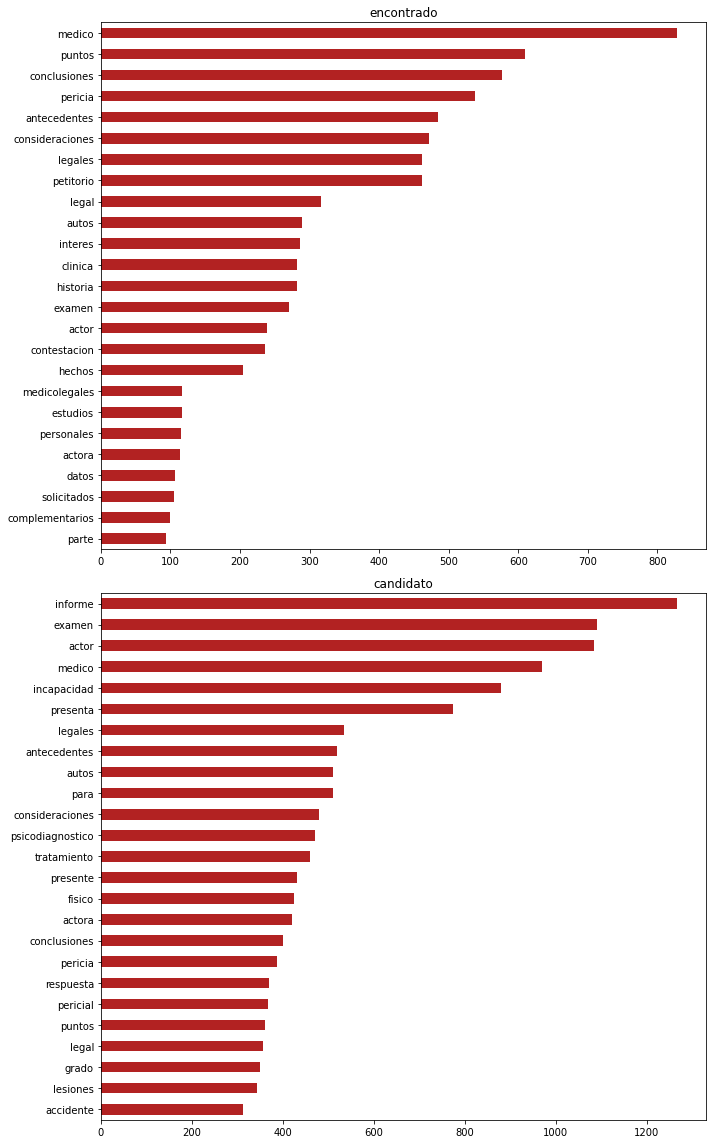

In [259]:
# Top 10 títulos por tipo 
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(10, 16))
for i, tipo in enumerate(titulos_tidy.tipo.unique()):
    df_temp = titulos_tidy[titulos_tidy.tipo == tipo]
    counts  = df_temp['token'].value_counts(ascending=False).head(25)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(tipo)

fig.tight_layout()

In [260]:
# Pivotado de títutlos por tipo y token.
# ==============================================================================
titulos_pivot = titulos_tidy.groupby(["tipo","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="tipo", values= "count")
titulos_pivot.columns.name = None

In [261]:
# tokens mas frecuentes en ambos tipos de titulos: Encontrados-Candidatos
for i, count in enumerate(titulos_pivot.encontrado):
    if titulos_pivot.candidato[i] > 80 and count > 80:
        print(titulos_pivot.index[i])

actor
actora
antecedentes
autos
clinica
complementarios
conclusiones
consideraciones
datos
estudios
examen
hechos
historia
incapacidad
interes
legal
legales
medico
parte
pericia
perito
personales
petitorio
puntos
solicitados


In [262]:
# Test de correlación (coseno) por títulos candidato y título encontrado
# ==============================================================================
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return distancia

matriz_corr = titulos_pivot.corr(method=similitud_coseno)

In [263]:
print('Correlación entre tipos de títulos')
matriz_corr

Correlación entre tipos de títulos


,candidato,encontrado
candidato,1.000000,0.402318
encontrado,0.402318,1.000000


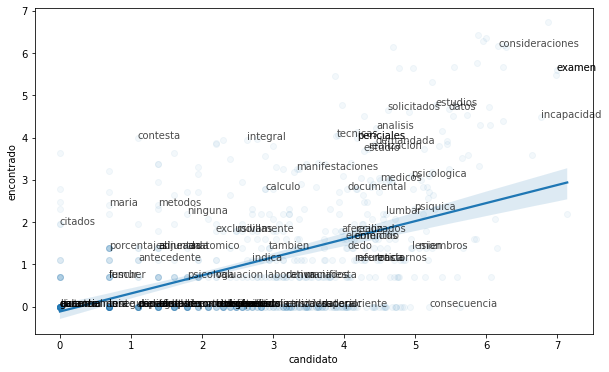

In [264]:
import seaborn as sns

# Gráfico de correlación
# ==============================================================================
f, ax = plt.subplots(figsize=(10, 6))
temp = titulos_pivot.dropna()
sns.regplot(
    x  = np.log(temp.candidato),
    y  = np.log(temp.encontrado),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.candidato[i]), np.log(temp.encontrado[i])),
        alpha = 0.7
    )

In [265]:
# Número de palabras comunes en títulos encotnrados y candidatos.
# ==============================================================================
titulo_encontrado = set(titulos_tidy[titulos_tidy.tipo == 'encontrado']['token'])
titulo_candidato = set(titulos_tidy[titulos_tidy.tipo == 'candidato']['token'])


print(f"Palabras comunes entre títulos encontrados y títulos candidatos: {len(titulo_encontrado.intersection(titulo_candidato))}")

Palabras comunes entre títulos encontrados y títulos candidatos: 708


In [266]:
# Cálculo del log of odds ratio de cada palabra títulos encontrados y títulos candidatos
# ==============================================================================
# Pivotaje y despivotaje
titulos_pivot = titulos_tidy.groupby(["tipo","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="tipo", values= "count")

titulos_pivot = titulos_pivot.fillna(value=0)
titulos_pivot.columns.name = None

titulos_unpivot = titulos_pivot.melt(value_name='n', var_name='tipo', ignore_index=False)
titulos_unpivot = titulos_unpivot.reset_index()

# Selección de los títlos encontrados y candidatos. 
titulos_unpivot = titulos_unpivot[titulos_unpivot.tipo.isin(['encontrado', 'candidato'])]

# Se añade el total de palabras de cada titulo.
titulos_unpivot = titulos_unpivot.merge(
                    titulos_tidy.groupby('tipo')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'tipo'
                 )

# Cálculo de odds y log of odds de cada palabra
titulos_logOdds = titulos_unpivot.copy()
titulos_logOdds['odds'] = (titulos_logOdds.n + 1) / (titulos_logOdds.N + 1)
titulos_logOdds = titulos_logOdds[['token', 'tipo', 'odds']] \
                    .pivot(index='token', columns='tipo', values='odds')
titulos_logOdds.columns.name = None

titulos_logOdds['log_odds']     = np.log(titulos_logOdds.encontrado/titulos_logOdds.candidato)
titulos_logOdds['abs_log_odds'] = np.abs(titulos_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser título encontrado. Esto es así porque el ratio sea ha
# calculado como encontrado/candidato.
titulos_logOdds['tipo_frecuente'] = np.where(titulos_logOdds.log_odds > 0,
                                              "encontrado",
                                              "candidato"
                                    )

In [267]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadas en títulos encontrados y tíulos candidatos')
print('-----------------------------------')
titulos_logOdds.sort_values('abs_log_odds', ascending=False).head(30)

-----------------------------------
Top 10 palabras más diferenciadas en títulos encontrados y tíulos candidatos
-----------------------------------


,candidato,encontrado,log_odds,abs_log_odds,tipo_frecuente
token,,,,,
galeano,0.000014,0.001836,4.905527,4.905527,encontrado
consultada,0.000014,0.001836,4.905527,4.905527,encontrado
auxiliares,0.000027,0.003114,4.740448,4.740448,encontrado
cardio,0.000014,0.001357,4.603246,4.603246,encontrado
bibliiografia,0.000014,0.001278,4.542622,4.542622,encontrado
analizados,0.000014,0.001118,4.409090,4.409090,encontrado
contesta,0.000054,0.004392,4.391072,4.391072,encontrado
preambulo,0.000014,0.001038,4.334982,4.334982,encontrado
letrados,0.000014,0.000958,4.254940,4.254940,encontrado


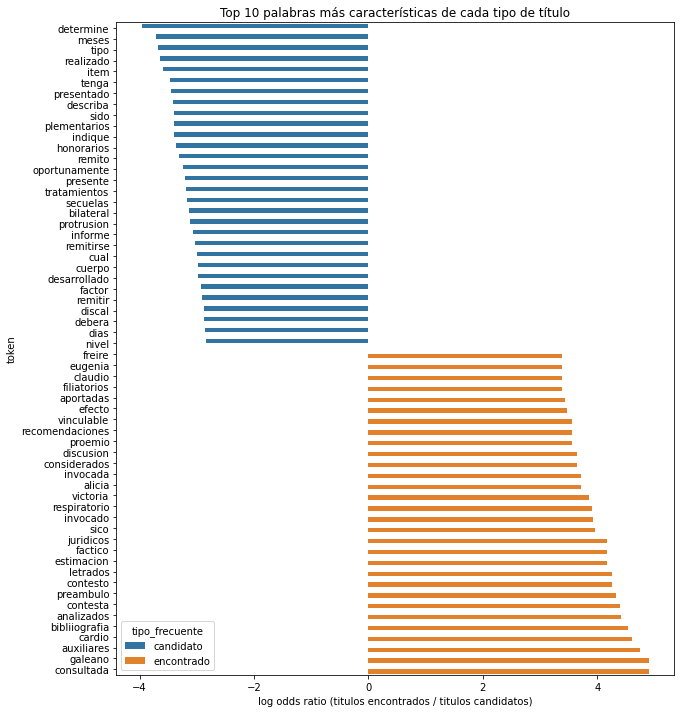

In [268]:
# Top 15 palabras más características de cada tipo de título
# ==============================================================================

top_30 = titulos_logOdds[['log_odds', 'abs_log_odds', 'tipo_frecuente']] \
        .groupby('tipo_frecuente') \
        .apply(lambda x: x.nlargest(30, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(10, 12))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'tipo_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 10 palabras más características de cada tipo de título')
ax.set_xlabel('log odds ratio (titulos encontrados / titulos candidatos)');

In [ ]:
print(f'''Títulos Encontrados: {len(dfUbicacionTitulos)}
Títulos Candidatos: {len(dfUbicacionTitulosCandidatos)}
''')

Títulos Encontrados: 2898
Títulos Candidatos: 24667



In [276]:
# Creamos un dataframe para colocar el salto de linea en formato HTML
dfLimpioHTML = dfExpSinTitulosRomanos.expediente.apply(str)
parrafoHTML = dfExpSinTitulosRomanos.expediente[5][6775:]
def limpiarTextoHTML(text):
    text = text.strip().replace('\n','<br>')
    return text

dfLimpioHTML = dfLimpioHTML.apply(limpiarTextoHTML)
parrafoHTML = limpiarTextoHTML(parrafoHTML)

colors = {
    'procedimientos': '#cd5c5c',
    'cuerpos': '#99ccff',
    'afecciones': '#ffa500'
}

body = f'''
        <p>
        {dfLimpioHTML[5]}
        </p>
        <br>
        '''
body = body.replace(parrafoHTML,f'<span style="background-color: #99ccff">{parrafoHTML}</span>')
for titulo in titulosMayusculas[0]:
    body = body.replace(titulo,f'<span style="background-color: #cd5c5c">{titulo}</span>')
with open('parrafos.html','w', encoding="utf-8") as f:
    f.write(body)